<a href="https://colab.research.google.com/github/Himika-Mishra/Dissertation/blob/main/Mnist_Distortion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from skimage.util import random_noise
from tqdm import tqdm
import random

In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Flatten the images and normalize the pixel values to [0, 1]
x_train = x_train.reshape((60000, 28 * 28)).astype('float32') / 255
x_test = x_test.reshape((10000, 28 * 28)).astype('float32') / 255

In [4]:
# Append the target arrays
y = np.concatenate((y_train, y_test))

In [5]:
# One-hot encode the target arrays
num_classes = 10
y_onehot = np.eye(num_classes)[y]

In [6]:
# Splitting the encoded labels into train and test
y_train = y_onehot[:60000]
y_test = y_onehot[-10000:]

In [8]:
# Function to distort the images 90%
def distort_images(images, distortion_level):
    distorted_images = []
    for image in tqdm(images):
        distorted_image = random_noise(image, var=distortion_level)
        distorted_images.append(distorted_image)
    return distorted_images

In [9]:
# Distort the training images
distorted_train_images = distort_images(x_train, 0.9)

# Distort the test images
distorted_test_images = distort_images(x_test, 0.9)

100%|██████████| 10000/10000 [00:01<00:00, 6176.39it/s]


In [12]:
# Create a dataframe to store the distorted images
x_train_distorted = pd.DataFrame()
x_train_distorted = distorted_train_images + distorted_test_images

In [13]:
# Create a dataframe of array of zeroes as labels for above distorted images
y_train_distorted = np.zeros((70000, 10))

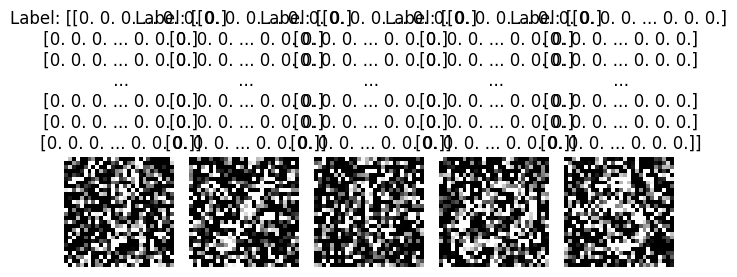

In [17]:
# Select 5 random indices
random_indices = random.sample(range(len(x_train_distorted)), 5)

# Retrieve the distorted images and labels at the selected indices
distorted_images = [x_train_distorted[i] if i < len(distorted_train_images) else distorted_test_images[i - len(distorted_train_images)] for i in random_indices]
labels = [y_train_distorted for i in random_indices]

# Display the distorted images
for i in range(5):
    image = distorted_images[i]
    label = labels[i]
    
    # Reshape the image back to its original shape (assuming it was flattened)
    image = image.reshape(28, 28)
    
    # Plot the image
    plt.subplot(1, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [18]:
# Initialize the merged train dataframe
merged_x_train = pd.DataFrame()

In [19]:
# Define the ratio of distorted images to select
ratios = np.arange(0.1, 1.1, 0.1)

In [28]:
# Convert the distorted train data from list and ndarray to DataFrame
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
x_train_distorted = pd.DataFrame(x_train_distorted)
y_train_distorted = pd.DataFrame(y_train_distorted)

In [29]:
# Iterate over the ratios
for ratio in ratios:
    # Calculate the number of distorted images to select based on the ratio
    num_distorted = int(len(x_train_distorted) * ratio)

    # Randomly select the specified number of distorted images
    selected_distorted_images = x_train_distorted.sample(n=num_distorted, random_state=42)
    selected_distorted_labels = y_train_distorted.sample(n=num_distorted, random_state=42)

    # Concatenate the selected distorted images with the original train dataframe
    merged_x_train = pd.concat([x_train, selected_distorted_images])
    merged_y_train = pd.concat([y_train, selected_distorted_labels])

    # Train and evaluate the model 
    # Fit a regular MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(10,8), activation='relu', solver='adam', max_iter=500)
    mlp.fit(merged_x_train, merged_y_train)
    # Accuracy Score
    test_acc = mlp.score(merged_x_train, merged_y_train)
    # print(mlp.score(merged_x_train, merged_y_train))
    print(f"Test accuracy with original_ratio={ratio}: {test_acc}")

    # predictions
    pred = mlp.predict(x_test)
    print(confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1)))
    print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))
    print("--------------------------------------------------")


Test accuracy with original_ratio=0.1: 0.9457164179104478
[[ 965    0    4    0    2    1    3    3    2    0]
 [  17 1093    3    3    0    3    1    1   14    0]
 [  51    2  924    9    7    1    4    9   25    0]
 [  60    1   16  884    2   13    2    7   24    1]
 [  23    0    1    0  923    1    7    1    2   24]
 [  58    1    0   26    1  774   12    2   15    3]
 [  23    3    2    0    4   10  906    0   10    0]
 [  33    4   20    2    3    0    0  951    1   14]
 [  45    5    2    4   11    8   13    2  880    4]
 [  36    1    0    8   26    3    0    9   24  902]]
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       980
           1       0.98      0.96      0.97      1135
           2       0.95      0.90      0.92      1032
           3       0.94      0.88      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.95      0.87      0.91       892
           6       0.96      0.9

In [ ]:
Test accuracy with original_ratio=0.1: 0.9457164179104478
[[ 965    0    4    0    2    1    3    3    2    0]
 [  17 1093    3    3    0    3    1    1   14    0]
 [  51    2  924    9    7    1    4    9   25    0]
 [  60    1   16  884    2   13    2    7   24    1]
 [  23    0    1    0  923    1    7    1    2   24]
 [  58    1    0   26    1  774   12    2   15    3]
 [  23    3    2    0    4   10  906    0   10    0]
 [  33    4   20    2    3    0    0  951    1   14]
 [  45    5    2    4   11    8   13    2  880    4]
 [  36    1    0    8   26    3    0    9   24  902]]
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       980
           1       0.98      0.96      0.97      1135
           2       0.95      0.90      0.92      1032
           3       0.94      0.88      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.95      0.87      0.91       892
           6       0.96      0.95      0.95       958
           7       0.97      0.93      0.94      1028
           8       0.88      0.90      0.89       974
           9       0.95      0.89      0.92      1009

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000


